Using experiment ID: 742893035574491603

 Model: ols 
 Spec: model_1 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2'] 
 Horizon: 1m

 Model: ols 
 Spec: model_2 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2', 'pmiCom', 'policyRate', 'UnempRate', 'termSpread', 'm1_gr', 'm3sa_gr', 'ip_gr', 'retailSales_gr'] 
 Horizon: 1m

 Model: ols 
 Spec: model_1 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2'] 
 Horizon: 3m

 Model: ols 
 Spec: model_2 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2', 'pmiCom', 'policyRate', 'UnempRate', 'termSpread', 'm1_gr', 'm3sa_gr', 'ip_gr', 'retailSales_gr'] 
 Horizon: 3m

 Model: ols 
 Spec: model_1 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2'] 
 Horizon: 12m

 Model: ols 
 Spec: model_2 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2', 'pmiCom', 'policyRate', 'UnempRate', 'termSpread', 'm1_gr', 'm3sa_gr', 'ip_gr', 'retailSales_gr'] 
 Horizon: 12m

 Model: ridge 
 Spec: model_1 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2'] 
 Horizon: 1m


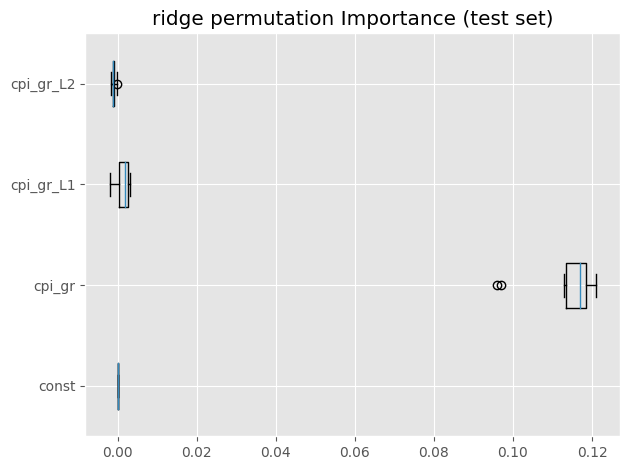

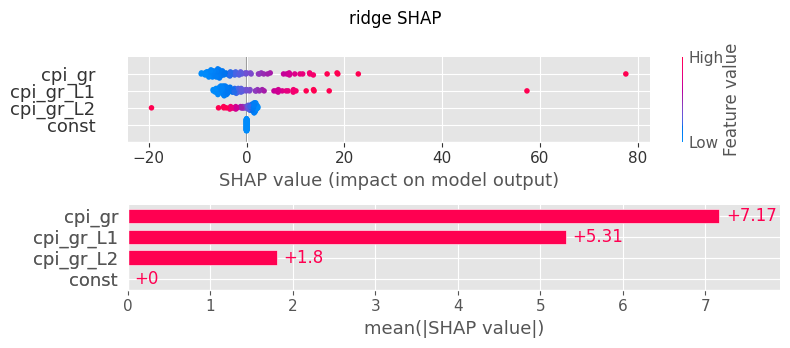

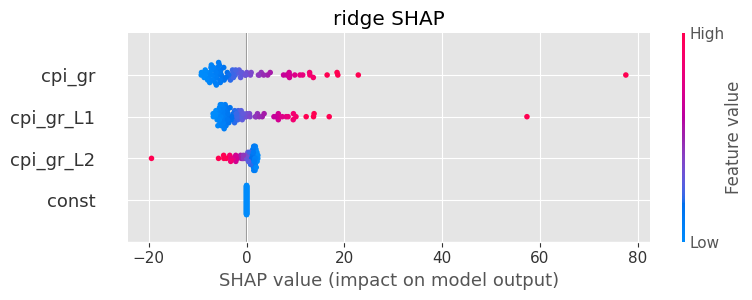


 Model: ridge 
 Spec: model_2 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2', 'pmiCom', 'policyRate', 'UnempRate', 'termSpread', 'm1_gr', 'm3sa_gr', 'ip_gr', 'retailSales_gr'] 
 Horizon: 1m


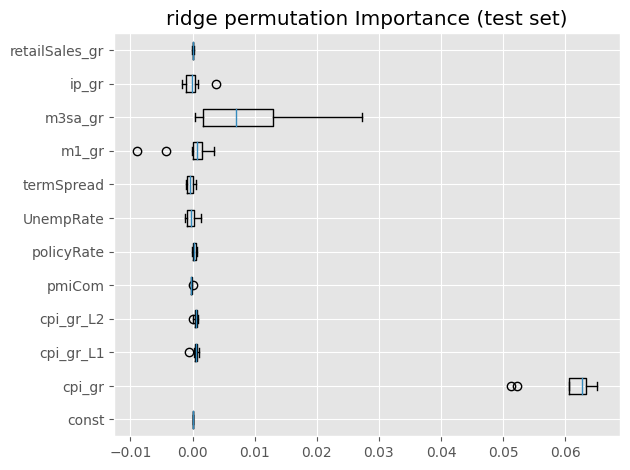

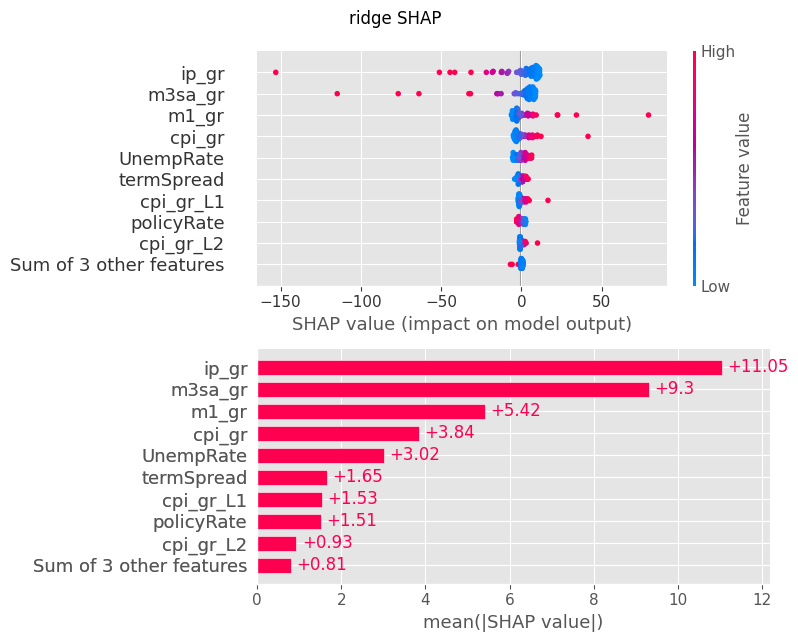

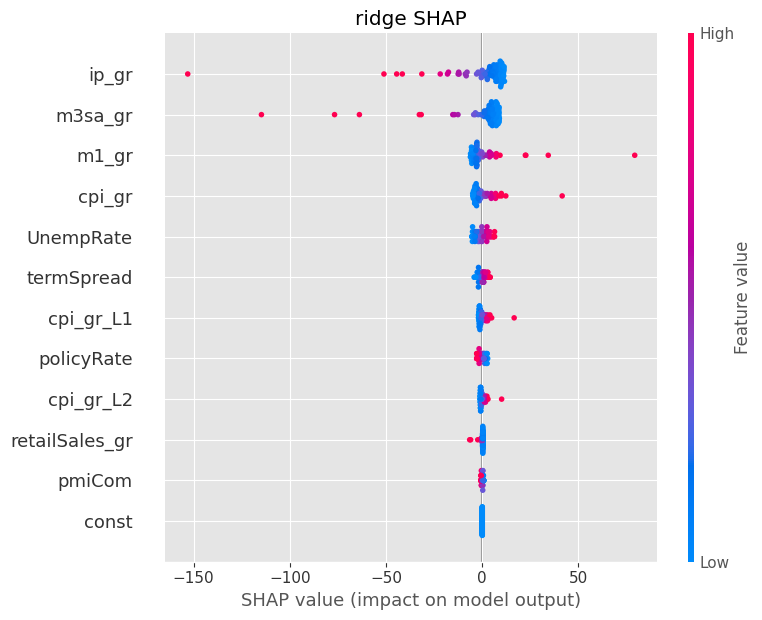


 Model: ridge 
 Spec: model_1 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2'] 
 Horizon: 3m


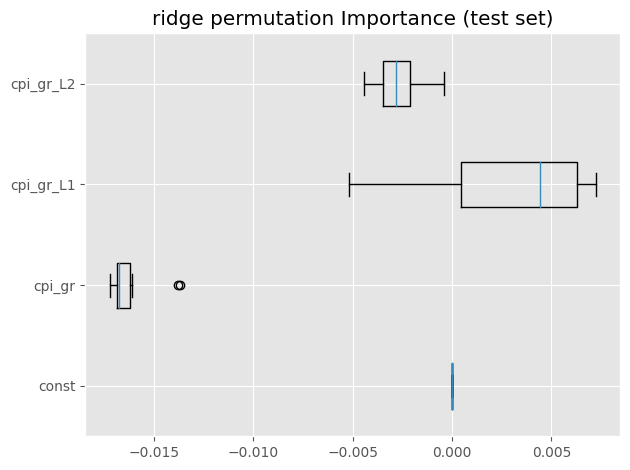

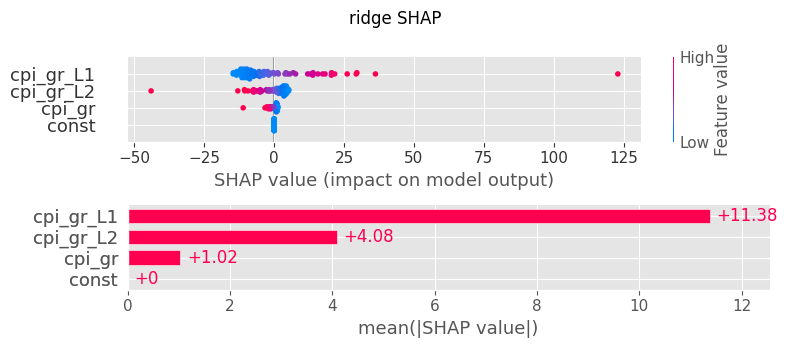

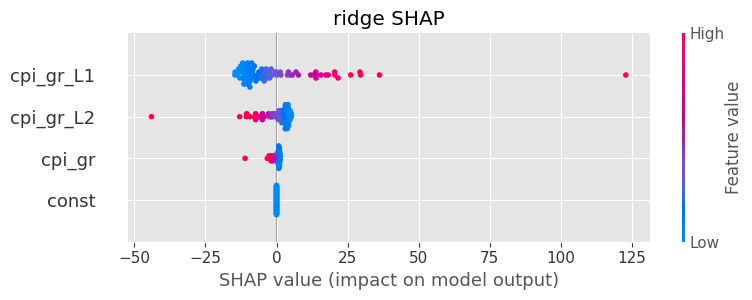


 Model: ridge 
 Spec: model_2 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2', 'pmiCom', 'policyRate', 'UnempRate', 'termSpread', 'm1_gr', 'm3sa_gr', 'ip_gr', 'retailSales_gr'] 
 Horizon: 3m


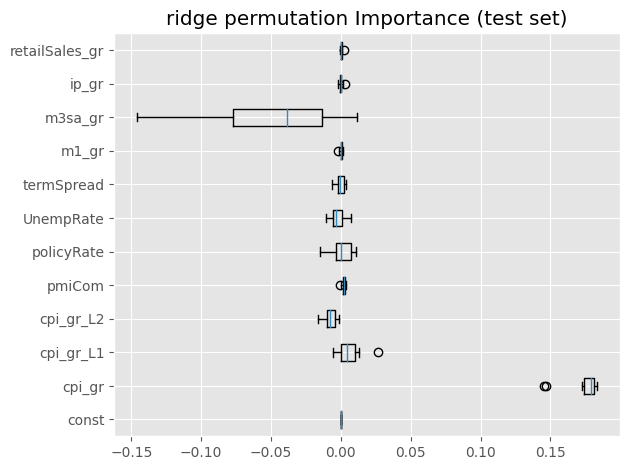

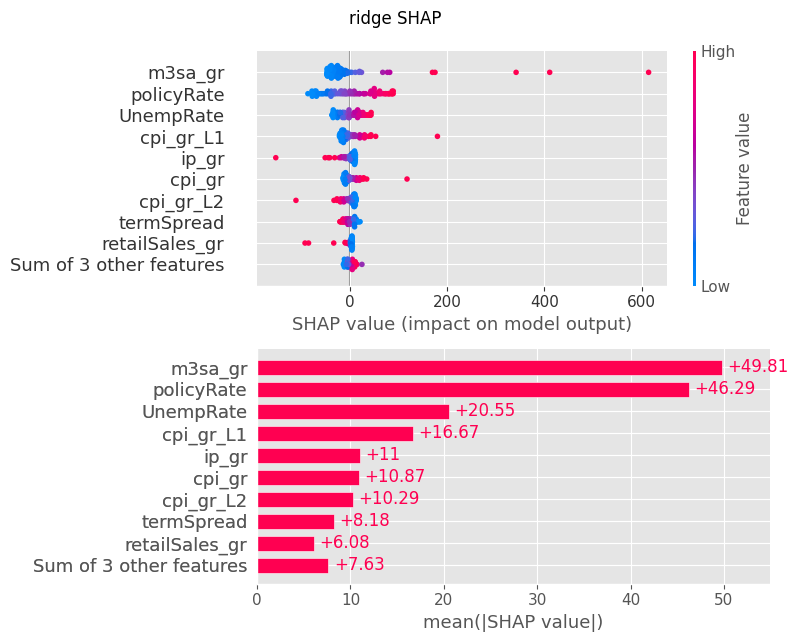

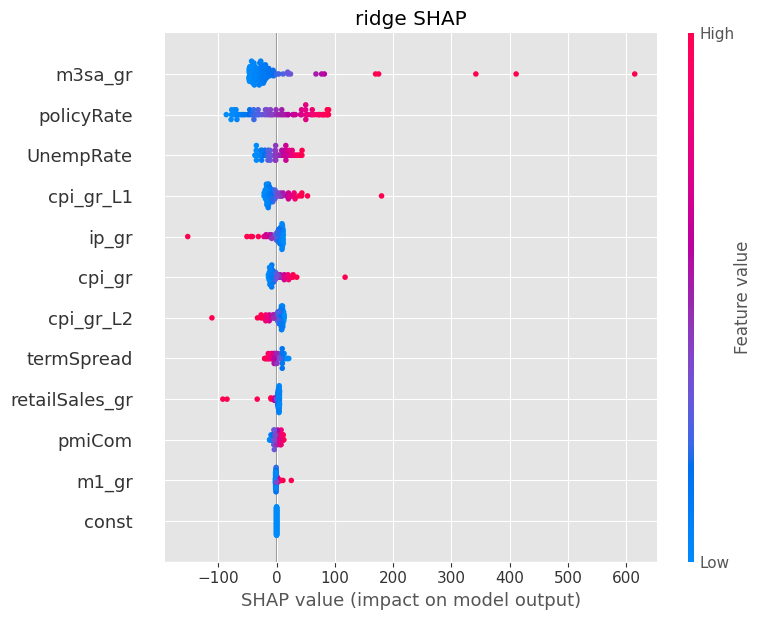


 Model: ridge 
 Spec: model_1 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2'] 
 Horizon: 12m


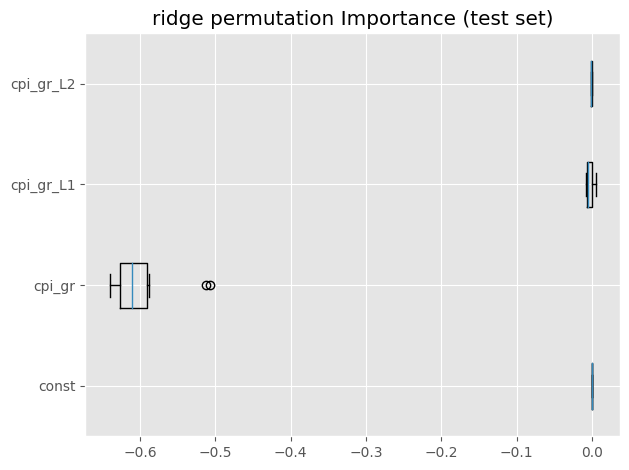

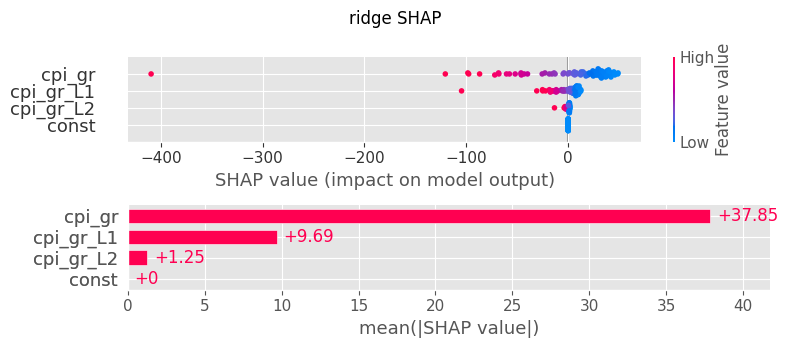

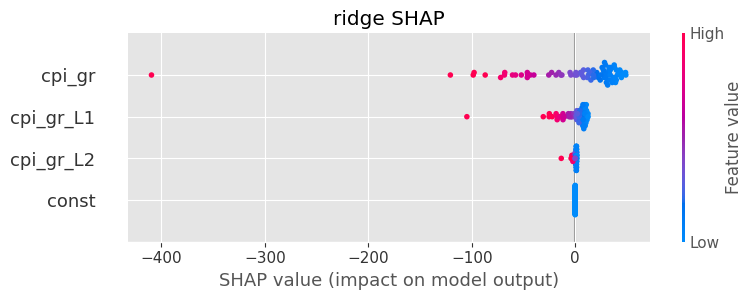


 Model: ridge 
 Spec: model_2 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2', 'pmiCom', 'policyRate', 'UnempRate', 'termSpread', 'm1_gr', 'm3sa_gr', 'ip_gr', 'retailSales_gr'] 
 Horizon: 12m


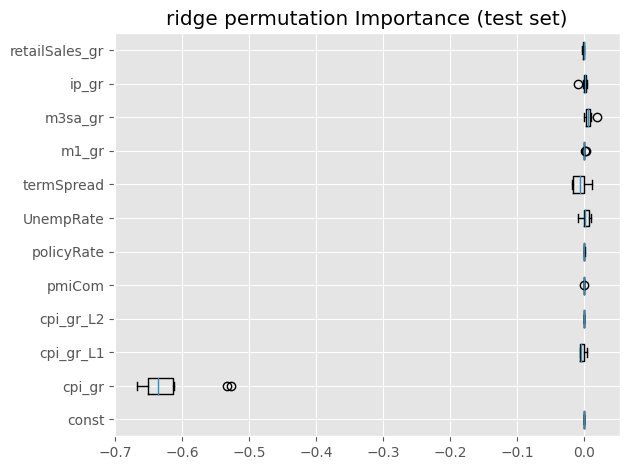

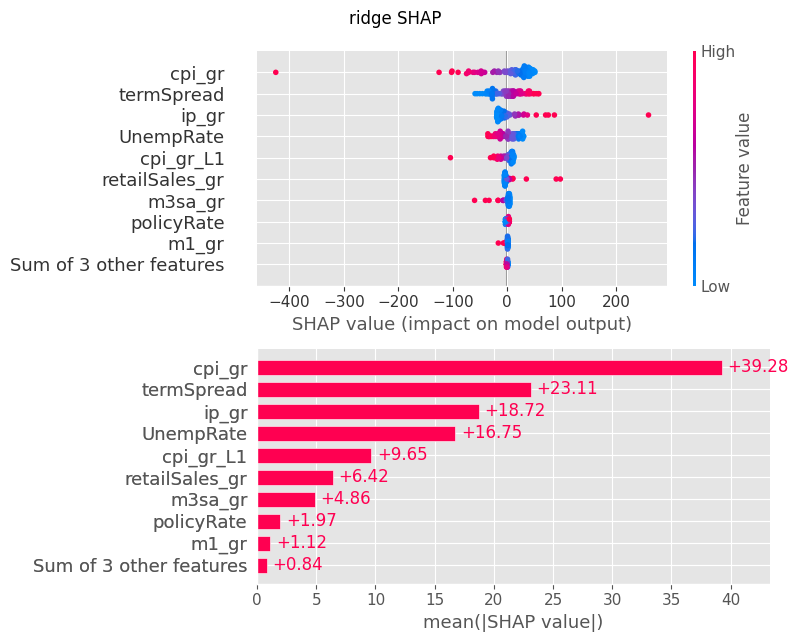

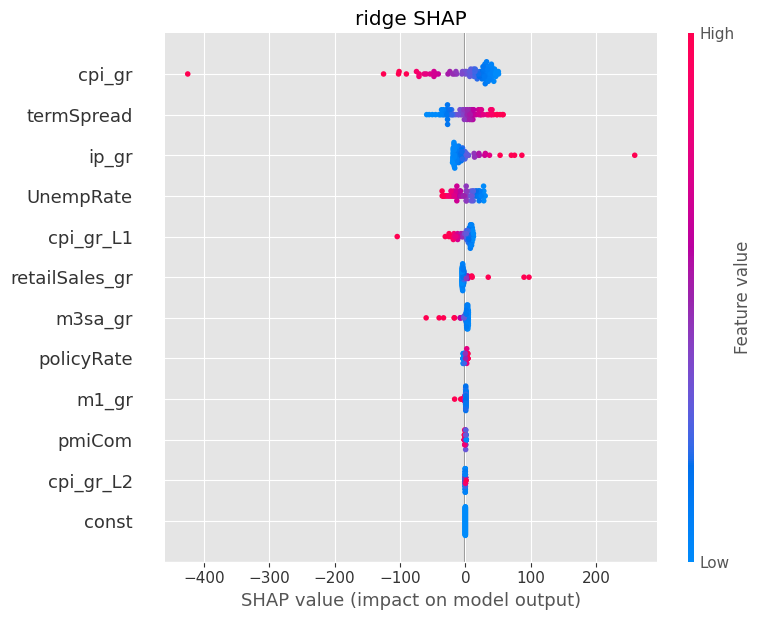


 Model: kernel_ridge 
 Spec: model_1 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2'] 
 Horizon: 1m


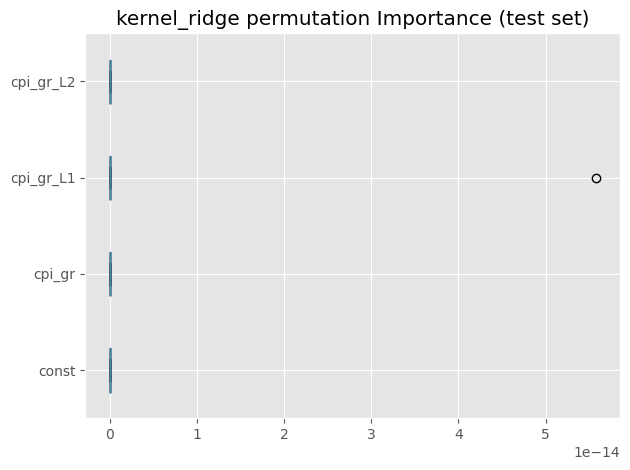

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

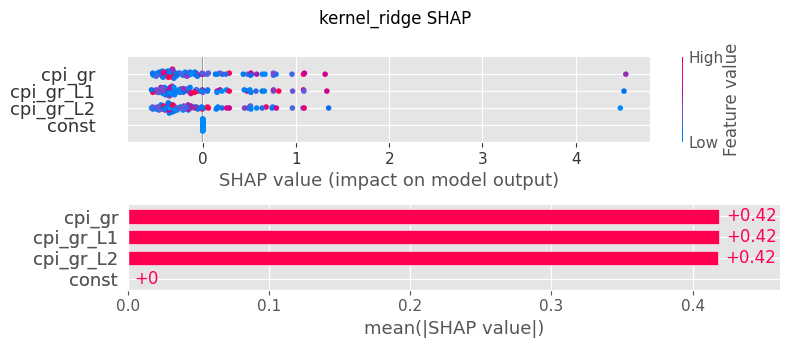

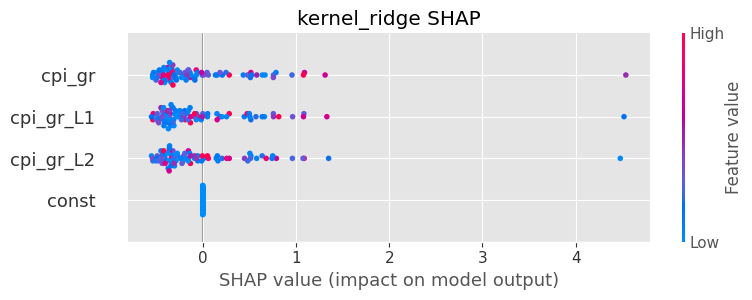


 Model: kernel_ridge 
 Spec: model_2 
 Spec vars: ['cpi_gr', 'cpi_gr_L1', 'cpi_gr_L2', 'pmiCom', 'policyRate', 'UnempRate', 'termSpread', 'm1_gr', 'm3sa_gr', 'ip_gr', 'retailSales_gr'] 
 Horizon: 1m


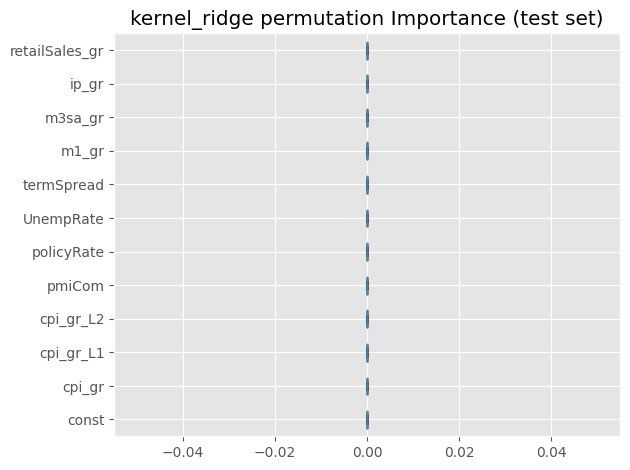

  0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
import logging

# %%
# Import necessary libraries
import os
from datetime import datetime
import tempfile

import matplotlib
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.api import VAR
import shap

matplotlib.style.use('ggplot')

# Get the current date
today = datetime.today().date().isoformat()
today_str = today.replace('-', '')

# Define the size of the DataFrame
size = 400
# Create a DataFrame with fake data
df = pd.DataFrame({
    'cpi': np.random.rand(size),
    'm1': np.random.rand(size),
    'm3sa': np.random.rand(size),
    'ip': np.random.rand(size),
    'retailSales': np.random.rand(size),
    'gvtYld10y': np.random.rand(size),
    'ShortGovYield': np.random.rand(size),
    'pmiCom': np.random.rand(size),
    'policyRate': np.random.rand(size),
    'UnempRate': np.random.rand(size)
})

# Define the start date and periods based on the size of the DataFrame
start_date = pd.to_datetime('2024-04-01') - pd.DateOffset(months=size-1)

# Create a date column with monthly frequency
df['date'] = pd.date_range(start=start_date, periods=size, freq='M')
df.set_index(df['date'], drop=True, inplace=True)

# Calculate percentage changes and add lag features
cols2calc = ['cpi','m1','m3sa','ip','retailSales']
df[[f'{c}_gr' for c in cols2calc]] = df[cols2calc].pct_change(12, fill_method=None) * 100
df['termSpread'] = df['gvtYld10y'] - df['ShortGovYield']

# Add lag features
df[[c + '_L1' for c in ['cpi_gr']][0]] = df['cpi_gr'].shift(1).copy()
df[[c + '_L2' for c in ['cpi_gr']][0]] = df['cpi_gr'].shift(2).copy()
df[[c + '_F1' for c in ['cpi_gr']][0]] = df['cpi_gr'].shift(-1).copy()
df[[c + '_F3' for c in ['cpi_gr']][0]] = df['cpi_gr'].shift(-3).copy()
df[[c + '_F12' for c in ['cpi_gr']][0]] = df['cpi_gr'].shift(-12).copy()

# Define columns to lag
cols2lag = ['pmiCom', 'policyRate', 'm3sa', 'm1', 'UnempRate', 
            'termSpread','m1_gr', 'm3sa_gr', 'ip_gr', 'retailSales_gr']

# Define model specifications
mod_1 = ['cpi_gr'] + [f'cpi_gr_{l}' for l in ['L1', 'L2']]
mod_2 = mod_1 + ['pmiCom', 'policyRate', 'UnempRate', 'termSpread', 'm1_gr', 'm3sa_gr', 'ip_gr', 'retailSales_gr']
mod_3 = mod_1 + ['policyRate']
mod_4 = mod_1 + ['termSpread', 'UnempRate']
mod_5 = mod_1 + ['m1_gr']
mod_6 = mod_1 + ['m3sa_gr']
mod_7 = mod_1 + ['retailSales_gr', 'ip_gr']

# Store models in a dictionary
models = {
    'model_1': mod_1,
    'model_2': mod_2
    #'model_3': mod_3,
    #'model_4': mod_4,
    #'model_5': mod_5,
    #'model_6': mod_6,
    #'model_7': mod_7
}

# Define training and test dates
train_start_date = '2010-03-01'
train_end_date = '2016-12-01'
test_start_date_1 = '2017-01-01'
test_end_date_1 = '2019-12-01'
test_start_date_2 = '2022-01-01'
test_end_date_2 = '2022-09-01'

# Split the data into training and testing sets
df_train = df.loc[(df.index >= train_start_date) & (df.index <= train_end_date), :].copy()
train_x = {mname: pd.DataFrame() for mname in models.keys()}
# Populate train_x with training data
for mname, varsname in models.items():
    train_x[mname] = df_train[varsname].dropna().copy()
    train_x[mname] = sm.add_constant(train_x[mname])

df_test_1 = df.loc[(df.index >= test_start_date_1) & (df.index <= test_end_date_1), :].copy()
test_x_1 = {mname: pd.DataFrame() for mname in models.keys()}
# Populate test_x_1 with test data
for mname, varsname in models.items():
    test_x_1[mname] = df_test_1[varsname].dropna().copy()
    test_x_1[mname] = sm.add_constant(test_x_1[mname])

df_test_2 = df.loc[(df.index >= test_start_date_2) & (df.index <= test_end_date_2), :].copy()
test_x_2 = {mname: pd.DataFrame() for mname in models.keys()}
# Populate test_x_2 with test data
for mname, varsname in models.items():
    test_x_2[mname] = df_test_2[varsname].dropna().copy()
    test_x_2[mname] = sm.add_constant(test_x_2[mname])

df_test = df.loc[(df.index > train_end_date) & (df.index <= test_end_date_2), :].copy()
test_x = {mname: pd.DataFrame() for mname in models.keys()}
# Populate test_x with test data
for mname, varsname in models.items():
    test_x[mname] = df_test[varsname].dropna().copy()
    test_x[mname] = sm.add_constant(test_x[mname])

# Define the target variable
y = df.filter(regex='_F').copy()
train_y = y[y.index.isin(df_train[varsname].dropna().index.tolist())].copy()
test_y_1 = df['cpi_gr'][df.index.isin(df_test_1.index.tolist())].copy()
test_y_2 = df['cpi_gr'][df.index.isin(df_test_2.index.tolist())].copy()
test_y = df['cpi_gr'][df.index.isin(df_test.index.tolist())].copy()

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define models and hyperparameters for benchmarking
ridge_model = Ridge()
ridge_params_grid = {"alpha": [100, 1e0, 1e-5]}

kernel_ridge_model = KernelRidge()
kr_params_grid = {"alpha": [100, 1e0, 1e-5],
                "kernel": ['linear', 'rbf'],
                "gamma": [1e0, 1e-5]}

rf_model = RandomForestRegressor()
rf_params_grid = {
    'bootstrap': [True],
    'max_depth': [80, 110],
    'n_estimators': [100, 1000],
    'random_state': [0]
}

gbr_model = GradientBoostingRegressor()
gbr_params_grid = {
    "n_estimators": [10, 500],
    "learning_rate": [0.0001, 1.0],
    "loss": ["squared_error"],
    "random_state": [0]
} 

xgb_model = xgb.XGBRegressor()
xgb_params_grid = {
    'subsample': [1],
    'max_depth': [3, 5],
    'gamma': np.linspace(0, 1, 3),
    'colsample_bytree': [0.15]
}

mlp_model = MLPRegressor(max_iter=1000)
mlp_params_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 200)],
    'activation': ['tanh'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0, 0.05],
    'learning_rate': ['constant'],
}

benchmarking_dict = {
    'ols': {'model': None, 'param_grid': None},
    #'var': {'model': None, 'param_grid': None},
    'ridge': {'model': ridge_model, 'param_grid': ridge_params_grid},
    'kernel_ridge': {'model': kernel_ridge_model, 'param_grid': kr_params_grid},
    'rf': {'model': rf_model, 'param_grid': rf_params_grid},
    'gbr': {'model': gbr_model, 'param_grid': gbr_params_grid},
    'xgb': {'model': xgb_model, 'param_grid': xgb_params_grid},
    'mlp': {'model': mlp_model, 'param_grid': mlp_params_grid}
}

# Specify horizons and metrics
horizon = ['1m', '3m', '12m']
metric = ['r2', 'rmse_1', 'rmse_2']

# Create a dictionary to store results
res = dict()

# Loop through each model for benchmarking
for model in benchmarking_dict.keys():
    # Initialize results dataframe         
    res[model] = pd.DataFrame(index=models.keys(), columns=pd.MultiIndex.from_product([horizon, metric], names=['horizon', 'metric']))
    # Loop through each target horizon
    for h in train_y.columns:
        hh = h.split('_')[-1].split('F')[-1] + 'm'
        # Loop through each model specification
        for modname, modvars in models.items():
            # Start an MLflow run
            with mlflow.start_run(run_name=f"inflation-{today_str}-{model}-{h}-{modname}", experiment_id=experiment_id):
                # Logging information    
                print(f'\n Model: {model} \n Spec: {modname} \n Spec vars: {modvars} \n Horizon: {hh}')
                mlflow.log_param("Model", model)
                mlflow.log_param("Spec", modname)
                mlflow.log_param("Spec_vars", modvars)
                mlflow.log_param("Horizon", hh)
                
                if model == 'ols':
                    ols_model = sm.OLS(train_y[h], train_x[modname])
                    res_fit = ols_model.fit()
                    pred_o = res_fit.predict(sm.add_constant(test_x[modname][train_x[modname].columns]))
                    pred_o_1 = res_fit.predict(sm.add_constant(test_x_1[modname][train_x[modname].columns]))
                    pred_o_2 = res_fit.predict(sm.add_constant(test_x_2[modname][train_x[modname].columns]))
                    pred_i = res_fit.predict(sm.add_constant(train_x[modname]))
                    best_params = None
                elif model == 'var':
                    cols2var = modvars  # Use current model's variables for VAR
                    train_data = df_train[cols2var].dropna().copy()
                    test_data = df_test[cols2var].dropna().copy()
                    var_model = VAR(train_data)
                    res_fit = var_model.fit(1)
                    pred_o = res_fit.forecast(train_data.values[-1:], len(test_data))
                    pred_o_1 = res_fit.forecast(train_data.values[-1:], len(df_test_1[cols2var].dropna()))
                    pred_o_2 = res_fit.forecast(train_data.values[-1:], len(df_test_2[cols2var].dropna()))
                    pred_i = res_fit.fittedvalues
                    best_params = None
                else:
                    # Grid search for hyperparameter tuning
                    model_paramSearch = GridSearchCV(benchmarking_dict[model]['model'], 
                                                    param_grid=benchmarking_dict[model]['param_grid'],
                                                    cv=tscv)
                    model_paramSearch.fit(train_x[modname], train_y[h])
                    best_params = model_paramSearch.best_params_
                    
                    # Fit the model with the best hyperparameters
                    res_fit = benchmarking_dict[model]['model'].set_params(**model_paramSearch.best_params_).fit(train_x[modname], train_y[h])

                    # Make predictions on test data
                    pred_o = res_fit.predict(test_x[modname])
                    pred_o_1 = res_fit.predict(test_x_1[modname])
                    pred_o_2 = res_fit.predict(test_x_2[modname])
                    pred_i = res_fit.predict(train_x[modname])
                
                # Log the resulting model
                mlflow.sklearn.log_model(res_fit, "model")

                # Log the best parameters
                if best_params:
                    for param, value in best_params.items():
                        mlflow.log_param(param, value)
                
                try:
                    coeff_ = pd.DataFrame(res_fit.params, index=train_x[modname].columns, columns=['coeff'])
                except Exception:
                    coeff_ = []
                
                # Calculate evaluation metrics
                r2 = r2_score(train_y[h], pred_i)
                rmse_1 = mean_squared_error(test_y_1, pred_o_1, squared=False)
                rmse_2 = mean_squared_error(test_y_2, pred_o_2, squared=False)
                res[model].loc[modname, (hh, 'r2')] = r2
                res[model].loc[modname, (hh, 'rmse_1')] = rmse_1
                res[model].loc[modname, (hh, 'rmse_2')] = rmse_2

                # Log metrics
                mlflow.log_metric("r2", r2)
                mlflow.log_metric("rmse_1", rmse_1)
                mlflow.log_metric("rmse_2", rmse_2)

                # Compute and log permutation importance if applicable
                if model not in ['ols', 'var']:
                    perm_imp = permutation_importance(res_fit, test_x[modname], test_y, n_repeats=10, random_state=0, n_jobs=2)
                    perm_imp_df = pd.DataFrame(perm_imp.importances[:].T, columns=test_x[modname].columns)
                    
                    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tempf:
                        perm_imp_df.to_csv(tempf.name, index=False)
                        mlflow.log_artifact(tempf.name, "permutation_importance.csv")
                
                    # Plot permutation importance
                    plt.boxplot(perm_imp_df, vert=False, labels=perm_imp_df.columns)
                    plt.title(f"{model} permutation Importance (test set)")
                    plt.tight_layout()
                    plt.savefig(f"{model}_perm_imp_{modname}.png")
                    plt.show()

                # Compute and log SHAP values if applicable
                if model not in ['ols', 'var']:
                    try:
                        if model == 'ridge':
                            explainer = shap.Explainer(res_fit, train_x[modname])
                        elif model == 'kernel_ridge':
                            explainer = shap.KernelExplainer(res_fit.predict, train_x[modname])
                        elif model == 'mlp':
                            explainer = shap.KernelExplainer(res_fit.predict, train_x[modname])
                        else:
                            explainer = shap.Explainer(res_fit)
                        
                        shap_values = explainer(train_x[modname])
                        shap_values_test = explainer(test_x[modname])
                        
                        plt.subplot(211)
                        shap.plots.beeswarm(shap_values, show=False, max_display=10)
                        plt.subplot(212)
                        shap.plots.bar(shap_values, show=False, max_display=10)
                        plt.suptitle(f"{model} SHAP")
                        plt.tight_layout()
                        plt.savefig(f"{model}_shap_{modname}.png")
                        plt.show()

                        shap.summary_plot(shap_values, train_x[modname], show=False)
                        plt.title(f"{model} SHAP")
                        plt.tight_layout()
                        plt.savefig(f"{model}_shapSummary_{modname}.png")
                        plt.show()
                        
                        # Save SHAP values
                        shap_values_df = pd.DataFrame(shap_values.values, columns=train_x[modname].columns)
                        with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tempf:
                            shap_values_df.to_csv(tempf.name, index=False)
                            mlflow.log_artifact(tempf.name, "shap_values.csv")

                    except Exception as e:
                        print(e)
                
                # Save results to a pickle file
                res2pkl = {
                    'fit': res_fit,
                    'pred_o': pred_o,
                    'pred_o_1': pred_o_1,
                    'pred_o_2': pred_o_1,
                    'train_x': train_x[modname],
                    'test_x': test_x[modname],
                    'test_x_1': test_x_1[modname],
                    'test_x_2': test_x_2[modname],
                    'train_y': train_y[h],
                    'test_y': test_y,
                    'test_y_1': test_y_1,
                    'test_y_2': test_y_2,
                    'pred_i': pred_i,
                    'coeff_': coeff_,
                    'r2': res[model].loc[modname, (hh, 'r2')],
                    'rmse_1': res[model].loc[modname, (hh, 'rmse_1')],
                    'rmse_2': res[model].loc[modname, (hh, 'rmse_2')],
                    'permutation_importance': perm_imp_df if model not in ['ols', 'var'] else None,
                    'shap': shap_values.values if model not in ['ols', 'var'] else None
                }
            
            #with open(f'{models_folder}{model}\\{model}_{modname}_{hh}.pkl','wb') as f:
            #    pickle.dump(res2pkl, f)
    
    # Save results to an Excel file        
    #res[model].to_excel(res_folder + f'{model}_V2.xlsx', sheet_name='data')

# Save overall results to a pickle file               
#with open(res_folder + '\\results_models_V2.pkl', 'wb') as f:
#    pickle.dump(res, f)

print("Experiment completed and logged.")


In [24]:
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path='best_model_artifacts')

'/home/jovyan/best_model_artifacts/'

In [27]:
csv_files_perm

['tmpkeawqz18.csv']

In [22]:
os.path.exists(shap_values_path)

False